Данный пример включает в себя ипользование библиотечной реализации метода CCM.

## **Тестирование метода ССМ на сигналах стокса и антистокса**

Один физический процесс взаимодействия лазерного излучения с
оптоволокном порождает две компоненты отражённого сигнала с разными
частотами - стоксовую и антистоксовую. Это случайные сигналы, и
чтобы пересчитать значение их амплитуд в температуру, их приходится
измерять по нескольку реализаций и рассчитывать среднее
арифметическое значение. В осциллографе это делает АЦП с записью.
Мы можем накопить и усреднить любое количество реализаций для
повышения точности измерений, но чем их больше, тем больше и шумы
арифметики, и где-то приходится останавливаться.

Для примменения метода CCM к нашим рядам установим необходимый модуль и подключим библиотеки:

In [ ]:
!pip install skccm

  Created wheel for skccm: filename=skccm-0.2.dev0-cp37-none-any.whl size=12592 sha256=0f2d97466338cf1a60778a21503237512d8f110fa18f2930f3af5f9313175ef7
  Stored in directory: /root/.cache/pip/wheels/9f/23/e2/aa730525818a1dd3265f5c65edc6f1eab652e83efa14c44831
Successfully built skccm


In [ ]:
import skccm as ccm
from skccm import Embed
from skccm.utilities import train_test_split
import pandas as pd
import numpy as np
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
%matplotlib inline

Загрузим наши временные ряды для сигналов стокса и антистокса:

Расшифровка названий:

as и s - это антистокс и стокс соответственно.

цифры после as и s- это количество усредненных реализаций:

1 - одна тысяча, 2 - две тысячи, ..., 5 - пять тысяч.

Имеются данные для 2х температур:

1 - 23 градусов, 2 - 79 град.


In [ ]:
initial = pd.read_csv('St_anti_23.csv', sep=';', decimal=',', dtype = "float64",
                      names= ['s1', 'as1', 's2', 'as2', 's3', 'as3', 's4', 'as4', 's5', 'as5'])
st_as_23 = initial.copy() # для температуры 23 граудуса

initial = pd.read_csv('St_anti_79.csv', sep=';', decimal=',', dtype = "float64",
                      names= ['s1', 'as1', 's2', 'as2', 's3', 'as3', 's4', 'as4', 's5', 'as5'])
st_as_79 = initial.copy() # 79 градусов

In [ ]:
st_as_23.head()

,s1,as1,s2,as2,s3,as3,s4,as4,s5,as5
0,-0.002679,0.000033,-0.002769,-0.000168,-0.002742,-0.001035,-0.002980,-0.001634,-0.003144,-0.001710
1,-0.002409,-0.000235,-0.003191,-0.000077,-0.002713,-0.000833,-0.002760,-0.001283,-0.002940,-0.001450
2,-0.001811,-0.000046,-0.003250,-0.000034,-0.002729,-0.000751,-0.003000,-0.001450,-0.003078,-0.001583
3,-0.002067,0.000009,-0.003441,0.000180,-0.002328,-0.000353,-0.002648,-0.001101,-0.002756,-0.001197
4,-0.002324,0.000253,-0.003435,0.000487,-0.002519,-0.000182,-0.002806,-0.000987,-0.002802,-0.001164


Прежде чем применить метод СCМ к данным, необходимо определить функции нахождения оптимальных параметров вложения (embedding) для дальнейшего построения лагового пространства (shadow manifold).


### **Функция для определение оптимального значения задержки (delay)**

In [ ]:
# Считаем взаимуню информацию по заданной задержке

def calc_MutualInformation(signal, delay, nBins, verbose):
    I = 0
    xmax = np.max(signal)
    xmin = np.min(signal)
    
    signalDelay = signal[delay:len(signal)] # все точки, кроме первой задержки
    signalOriginal = signal[0:len(signal)-delay] # кроме последней задержки

    binsize = np.abs(xmax - xmin) / nBins
    
    # словари для ускорения процесса
    probInBin = {} # P_k
    # P_hk
    conditionBin = {}
    conditionDelayBin = {}
    
    for h in range(0, nBins):
        if h not in probInBin:
            conditionBin.update({h : (signalOriginal >= (xmin+h*binsize)) & (signalOriginal < (xmin+(h+1)*binsize))})
            probInBin.update({h : len(signalOriginal[conditionBin[h]]) / len(signalOriginal)})
        for k in range(0, nBins):
            if k not in probInBin:
                conditionBin.update({k : (signalOriginal >= (xmin+k*binsize)) & (signalOriginal < (xmin+(k+1)*binsize))})
                probInBin.update({k : len(signalOriginal[conditionBin[k]]) / len(signalOriginal)})
            if k not in conditionDelayBin:
                conditionDelayBin.update({k : (signalDelay >= (xmin+k*binsize)) & (signalDelay < (xmin+(k+1)*binsize))})
            Phk = len(signalOriginal[conditionBin[h] & conditionDelayBin[k]]) / len(signalOriginal)
            if Phk != 0 and probInBin[h] != 0 and probInBin[k] != 0:
                I -= Phk * math.log(Phk / (probInBin[h]*probInBin[k]))

    return I

### **Функция для определения оптимальной размерности**



In [ ]:
def computeFNN(signal, delay, dimension, R_thr=10):
    embeddedData = np.array([signal[0:len(signal)-delay*dimension]])
    for i in range(1, dimension):
      embeddedData = np.append(embeddedData, [signal[i*delay:len(signal) - delay*(dimension-i)]], axis=0)
    embSig = embeddedData.transpose()

    # т.к. 1й ближайший сосед - сама точка ряда, то берем 2го ближайшего соседа
    nbr = NearestNeighbors(n_neighbors=2).fit(embSig)

    # ищем k ближайших соседа точки
    distance, index = nbr.kneighbors(embSig) # возвращает расстояния до соседей каждой точки и индексы соседей

    epsilon = np.std(distance.flatten())
    distDiff = np.diff(distance) # разность между последовательными элементами

    nFNN = 0
    # ищем количество ложных ближайших соседей
    for i in range(0, len(signal)-delay*(dimension+1)):
        if distance[i,1] == 0: # во избежание деления на ноль
            R = abs(signal[i+dimension*delay] - signal[index[i,1]+dimension*delay]) / 0.01 # нормализуем расстояние
        else:
            R = abs(signal[i+dimension*delay] - signal[index[i,1]+dimension*delay-1]) / distance[i,1] # нормализуем расстояние
        if (0 < distDiff[i+1]) and (distDiff[i+1] < epsilon) and (R > R_thr):
            nFNN += 1

    return nFNN

### **Определение оптимальных значений задержки и размерности**

In [ ]:
def find_lag_opt(nDelay, signalX, signalY, nBins, verbose=0):
    delay_vector = np.arange(1, nDelay + 1)
    info_vectorX = []
    info_vectorY = []
    
    for i in delay_vector:
        info_vectorX = np.append(info_vectorX, [calc_MutualInformation(signalX, i, nBins, verbose=verbose)])
        info_vectorY = np.append(info_vectorY, [calc_MutualInformation(signalY, i, nBins, verbose=verbose)])
     
    idx_minI_X = np.argmin(info_vectorX)
    idx_minI_Y = np.argmin(info_vectorY)
    
    lag_optX = delay_vector[idx_minI_X]
    lag_optY = delay_vector[idx_minI_Y]
    
    return lag_optX, lag_optY

In [ ]:
def find_dim_opt(nDim, signalX, signalY, tauX, tauY):
    dim_range = np.arange(1, nDim+1)
    num_FNN_X = []
    num_FNN_Y = []
    
    for i in dim_range:
        num_FNN_X = np.append(num_FNN_X, [computeFNN(signalX, tauX, i)])
        num_FNN_Y = np.append(num_FNN_Y, [computeFNN(signalY, tauY, i)])
        
    idx_minDim_X = np.argmin(num_FNN_X)
    idx_minDim_Y = np.argmin(num_FNN_Y)
    
    dim_optX = dim_range[idx_minDim_X]
    dim_optY = dim_range[idx_minDim_Y]
    
    return dim_optX, dim_optY

### **Применение метода СCМ**

**Гипотеза:**

Чем больше реализаций усредняется, тем сильнее
должна быть зависимость стокс-антистокс.

In [ ]:
def compute_CCM(x1, x2, nDelay, nDim, nBins=100):
  """
    Функция реализует метод ССМ для двух рядов x1, x2 по заданным начальным параметрам задержки и размерности

    Parameters
    ----------
    x1: 1d array
        исходные данные
    
    x2: 1d array
        исходные данные

    nDelay: int
        максимально возможная задержка
    
    nDim: int
        максимально возможная размерность пространства

    nBins: int
        количество сегментов данных

    Returns
    -------
    sc1: 2d array
        коэфициенты корреляции CCM: Cxy

    sc2: 2d array
        коэфициенты корреляции CCM: Cyx
  """

  if nDelay*nDim > len(x1) or nDelay*nDim > len(x2):
    raise NameError('Ошибка! Задержка*размерность превышает длину временного ряда. Измените параметры!')

  # ищем оптимальные значения задержки
  lagX, lagY = find_lag_opt(nDelay, x1, x2, nBins)
  lag = lagX

  # ищем оптимальные значения размерностей эмбэддингов
  dim_optX, dim_optY = find_dim_opt(nDim, x1, x2, lagX, lagY)

  # проверка, что два лаговых пространства (shadow manifolds) имеют одинаковую размерность
  if dim_optX != dim_optY:
    embed = max(dim_optX, dim_optY)
  else:
    embed = dim_optX

  # строим эмбэддинги временных рядов по заданным параметрам
  e1 = ccm.Embed(x1)
  e2 = ccm.Embed(x2)
  # переводим векторы из одномерного временного ряда в m-мерное пространство (т.е. строим лаговое пространство)
  X1 = e1.embed_vectors_1d(lag,embed)
  X2 = e2.embed_vectors_1d(lag,embed)

  # разбиваем ряды на обучающую и тестовую выборки
  x1_train, x1_test, x2_train, x2_test = train_test_split(X1, X2, percent=.75)
  CCM = ccm.CCM() # инициализируем класс CCM
  # задаем длину выборки: берем 30 точек от embed+1 до длины x1tr
  lib_lens = np.arange(embed+1, len(x1_train), len(x1_train)/30, dtype='int')
  # обучаем CCM и считаем коэфициенты корреляции
  CCM.fit(x1_train, x2_train)
  x1p, x2p = CCM.predict(x1_test, x2_test, lib_lengths=lib_lens)
  sc1,sc2 = CCM.score()

  return sc1, sc2

In [ ]:
# Начальные параметры
nDelay = 50 # максимально возможная задержка
nBins = 100 # количество сегментов данных
nDim = 50 # максимально возможная размерность пространства

Протестируем на сигналах при температуре **23 градуса**:

 Ряды стокс-антистокс при температуре 23 градуса:


 1 тыс. усредненных реализаций:


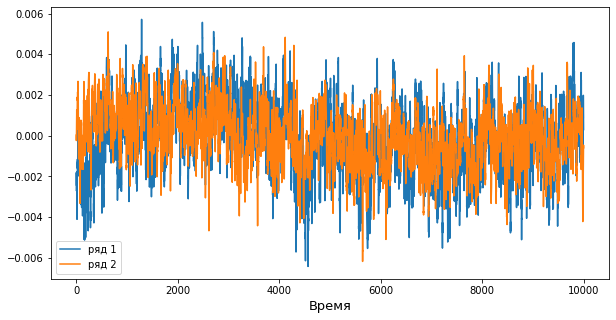

Коэфициенты корреляции CCM рядов:
Cxy = 0.11343625448053131
Cyx = 0.055976256923816546




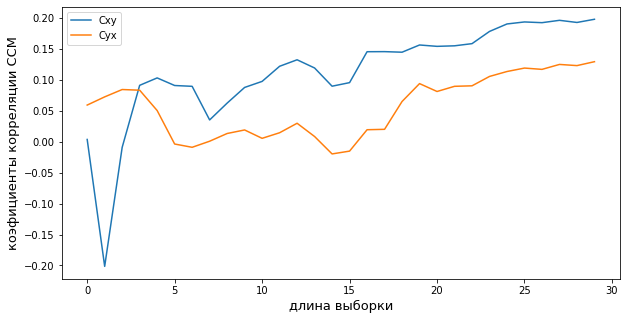

 2 тыс. усредненных реализаций:


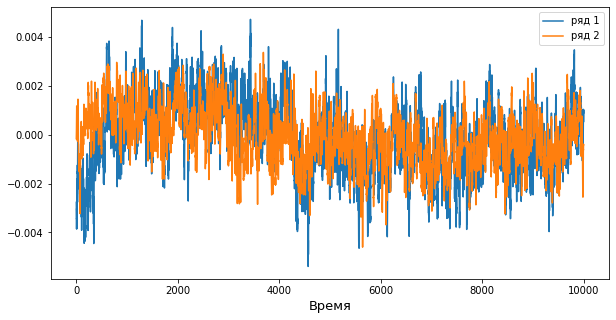

Коэфициенты корреляции CCM рядов:
Cxy = 0.14215561187220085
Cyx = 0.15054172798387838




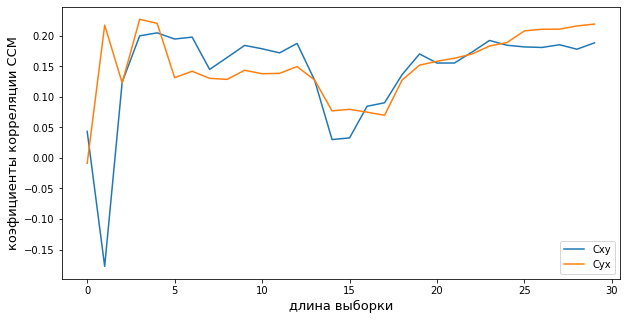

 3 тыс. усредненных реализаций:


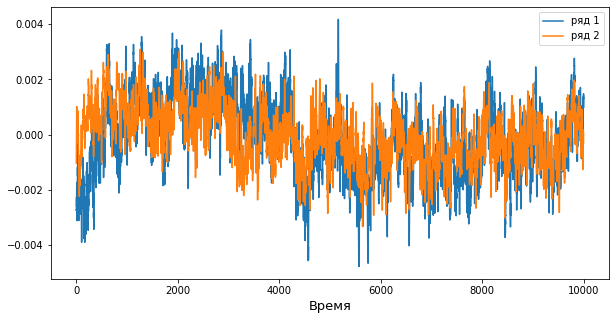

Коэфициенты корреляции CCM рядов:
Cxy = 0.25771640439059074
Cyx = 0.1836611560358753




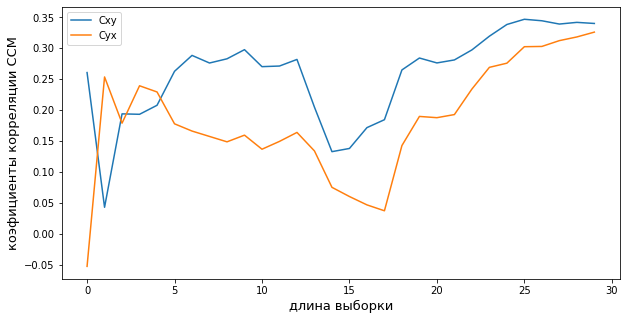

 4 тыс. усредненных реализаций:


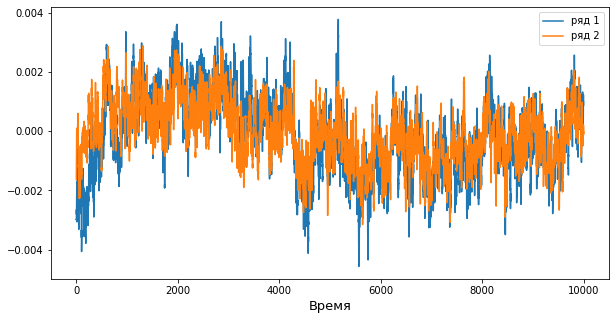

Коэфициенты корреляции CCM рядов:
Cxy = 0.55186548744512
Cyx = 0.49091603852033533




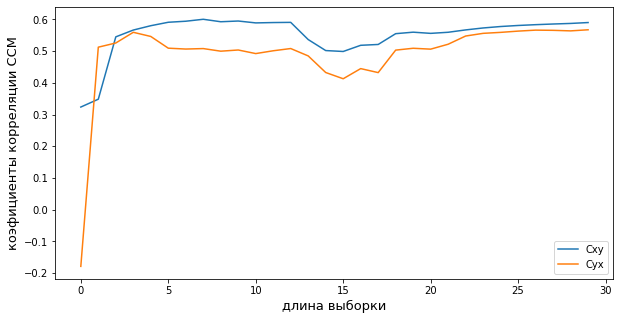

 5 тыс. усредненных реализаций:


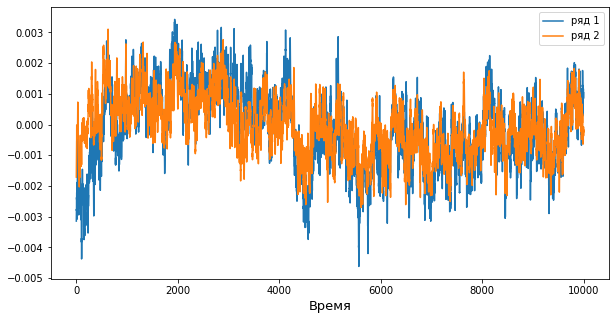

Коэфициенты корреляции CCM рядов:
Cxy = 0.5360808859446066
Cyx = 0.46227200651221967




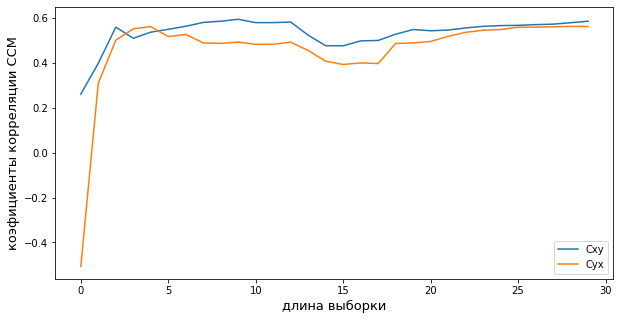

In [ ]:
print("\033[1m Ряды стокс-антистокс при температуре 23 градуса:\n\n")

for i in range(1, 6): # проходимся по 5-ти парам рядов
  print("\033[1m {} тыс. усредненных реализаций:".format(i))

  x1 = np.asarray(st_as_23['s'+str(i)][:10000])
  x2 = np.asarray(st_as_23['as'+str(i)][:10000])

  # строим на одном графике 2 временных ряда
  plt.figure(figsize=(10,5))
  plt.plot(x1)
  plt.plot(x2)
  plt.xlabel('Время', fontsize = 13)
  plt.legend(['стокс', 'антистокс'], loc = 'best')
  plt.show()

  # примением ССМ
  sc1, sc2 = compute_CCM(x1, x2, nDelay, nDim, nBins)

  # выводим среднее по коэфициентам корреляции CCM
  print("Коэфициенты корреляции CCM рядов:\nCxy = {}\nCyx = {}\n\n".format(np.mean(sc1),np.mean(sc2)))

  # строим зависимость коэфициентов корреляции CCM от длины выборки
  plt.figure(figsize=(10,5))
  plt.plot(sc1)
  plt.plot(sc2)
  plt.xlabel('длина выборки', fontsize = 13)
  plt.ylabel('коэфициенты корреляции CCM', fontsize = 13)
  plt.legend(['Cxy', 'Cyx'], loc = 'best')
  plt.show()

Протестируем на сигналах при температуре **79 градусов**:

 Ряды стокс-антистокс при температуре 79 градусов:


 1 тыс. усредненных реализаций:


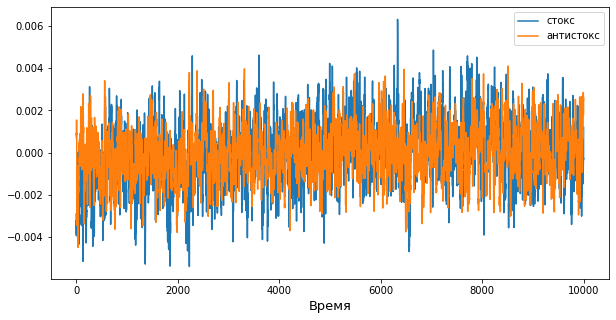

Коэфициенты корреляции CCM рядов:
Cxy = -0.019789255906148003
Cyx = -0.005213441411014467




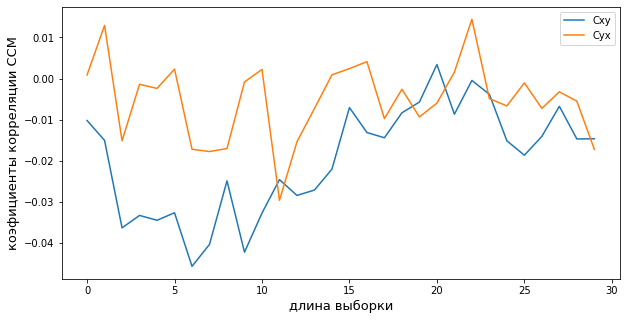

 2 тыс. усредненных реализаций:


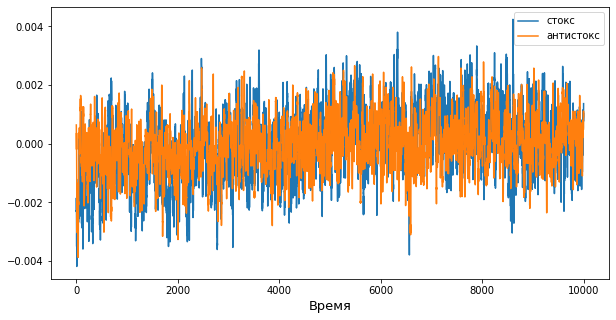

Коэфициенты корреляции CCM рядов:
Cxy = 0.025254010189775952
Cyx = 0.016385249356846078




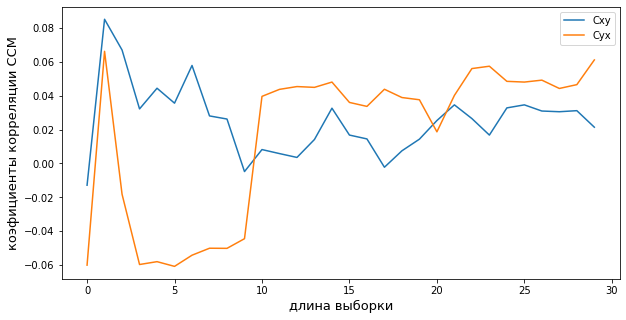

 3 тыс. усредненных реализаций:


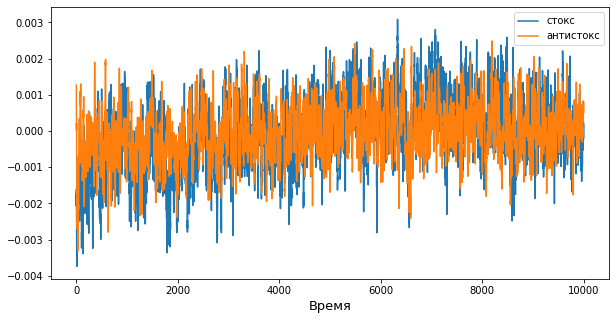

Коэфициенты корреляции CCM рядов:
Cxy = 0.04589600833868585
Cyx = 0.028570372574966096




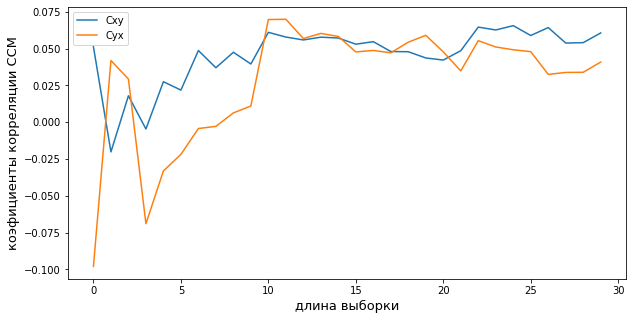

 4 тыс. усредненных реализаций:


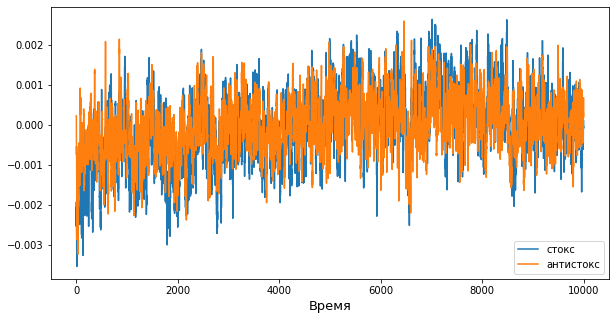

Коэфициенты корреляции CCM рядов:
Cxy = 0.2653301043507021
Cyx = 0.2521741252111401




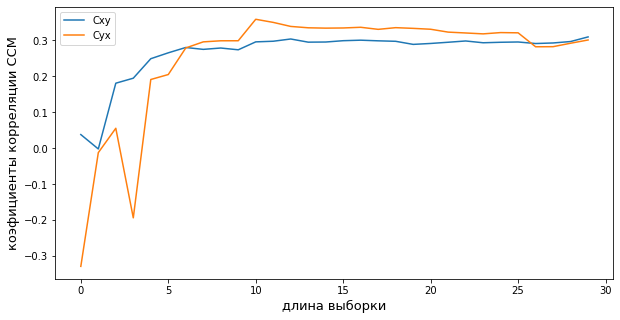

 5 тыс. усредненных реализаций:


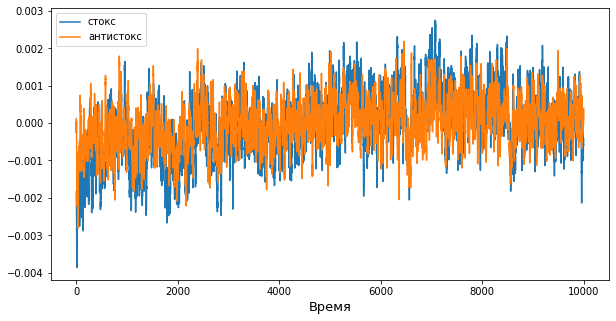

Коэфициенты корреляции CCM рядов:
Cxy = 0.2631013786608484
Cyx = 0.21559979178758465




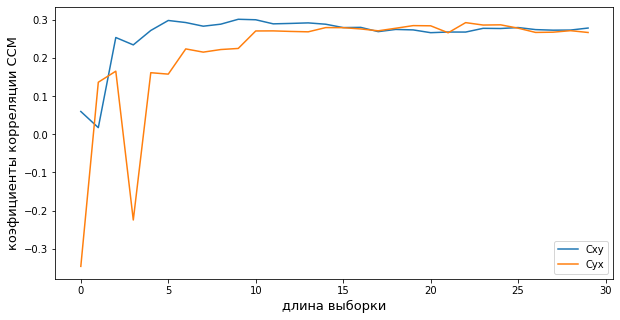

In [ ]:
print("\033[1m Ряды стокс-антистокс при температуре 79 градусов:\n\n")

for i in range(1, 6): # проходимся по 5-ти парам рядов
  print("\033[1m {} тыс. усредненных реализаций:".format(i))

  x1 = np.asarray(st_as_79['s'+str(i)][:10000])
  x2 = np.asarray(st_as_79['as'+str(i)][:10000])

  # строим на одном графике 2 временных ряда
  plt.figure(figsize=(10,5))
  plt.plot(x1)
  plt.plot(x2)
  plt.xlabel('Время', fontsize = 13)
  plt.legend(['стокс', 'антистокс'], loc = 'best')
  plt.show()

  # примением ССМ
  sc1, sc2 = compute_CCM(x1, x2, nDelay, nDim, nBins)

  # выводим среднее по коэфициентам корреляции CCM
  print("Коэфициенты корреляции CCM рядов:\nCxy = {}\nCyx = {}\n\n".format(np.mean(sc1),np.mean(sc2)))

  # строим зависимость коэфициентов корреляции CCM от длины выборки
  plt.figure(figsize=(10,5))
  plt.plot(sc1)
  plt.plot(sc2)
  plt.xlabel('длина выборки', fontsize = 13)
  plt.ylabel('коэфициенты корреляции CCM', fontsize = 13)
  plt.legend(['Cxy', 'Cyx'], loc = 'best')
  plt.show()

Тем самым подтверждается гипотеза о том, что зависимость между стоксом и антистоксов усиливаться с ростом количества усредненных реализаций. Усреднение количества реализаций повышет точности измерений, однако чем их больше, тем больше и шумы арифметики, поэтому уже при 5 тыс. реализаций коэффициенты корреляции CCM сигналов становятся немного хуже, чем при 4 тыс.

Также для большинства пар рядов $C_{XY} > C_{YX}$.

Для температуры 79 градусов результаты довольно плохие, т.к. тепловой шум становится намного больше, ряды оказываются связаны намного меньше.